In [1]:
# from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import PromptTemplate

### Indexing (Document Ingestion)

In [2]:
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api._errors import (
    TranscriptsDisabled,
    NoTranscriptFound,
    VideoUnavailable,
    CouldNotRetrieveTranscript,
)

video_id = "wjZofJX0v4M"

try:
    # 1. Create an instance of the API
    api = YouTubeTranscriptApi()
    # 2. Use the .fetch() method on the instance
    fetched_transcript = api.fetch(video_id, languages=["en"])
    # 3. Convert the result to a list of dictionaries
    transcript_list = fetched_transcript.to_raw_data()
    
    # Your existing code to process the list
    transcript = " ".join(chunk["text"] for chunk in transcript_list)
    print(transcript)

except TranscriptsDisabled:
    print("Captions are disabled for this video.")
except NoTranscriptFound:
    print("No English transcript found (manual or auto).")
except VideoUnavailable:
    print("Video is unavailable.")
except CouldNotRetrieveTranscript as e:
    print("Transcript exists but could not be retrieved:", e)

The initials GPT stand for Generative Pretrained Transformer. So that first word is straightforward enough, these are bots that generate new text. Pretrained refers to how the model went through a process of learning from a massive amount of data, and the prefix insinuates that there's more room to fine-tune it on specific tasks with additional training. But the last word, that's the real key piece. A transformer is a specific kind of neural network, a machine learning model, and it's the core invention underlying the current boom in AI. What I want to do with this video and the following chapters is go through a visually-driven explanation for what actually happens inside a transformer. We're going to follow the data that flows through it and go step by step. There are many different kinds of models that you can build using transformers. Some models take in audio and produce a transcript. This sentence comes from a model going the other way around, producing synthetic speech just from

In [3]:
transcript_list

[{'text': 'The initials GPT stand for Generative Pretrained Transformer.',
  'start': 0.0,
  'duration': 4.56},
 {'text': 'So that first word is straightforward enough, these are bots that generate new text.',
  'start': 5.22,
  'duration': 3.8},
 {'text': 'Pretrained refers to how the model went through a process of learning',
  'start': 9.8,
  'duration': 3.381},
 {'text': "from a massive amount of data, and the prefix insinuates that there's",
  'start': 13.181,
  'duration': 3.429},
 {'text': 'more room to fine-tune it on specific tasks with additional training.',
  'start': 16.61,
  'duration': 3.43},
 {'text': "But the last word, that's the real key piece.",
  'start': 20.72,
  'duration': 2.18},
 {'text': 'A transformer is a specific kind of neural network, a machine learning model,',
  'start': 23.38,
  'duration': 4.191},
 {'text': "and it's the core invention underlying the current boom in AI.",
  'start': 27.571,
  'duration': 3.429},
 {'text': 'What I want to do with this v

In [4]:
len(transcript)

29115

## Chunking the data 

In [5]:
splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=100)
chunks = splitter.create_documents([transcript])

In [6]:
chunks[0]

Document(metadata={}, page_content="The initials GPT stand for Generative Pretrained Transformer. So that first word is straightforward enough, these are bots that generate new text. Pretrained refers to how the model went through a process of learning from a massive amount of data, and the prefix insinuates that there's more room to fine-tune it on specific tasks with additional training. But the last word, that's the real key piece. A transformer is a specific kind of neural network, a machine learning model, and it's the core invention underlying the current boom in AI. What I want to do with this video and the following")

In [7]:
len(chunks)

59

### Indexing( Embedding Generation and Storing in Vector Store)

In [8]:
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="gemma:2b")

vector_store = FAISS.from_documents(chunks, embeddings)

In [9]:
vector_store.index_to_docstore_id

{0: 'd45f4105-7dbc-4a57-9774-498358539c16',
 1: '72d20949-65cf-48d6-8349-908b2721b1e7',
 2: 'c50c3084-be48-4401-88a1-3328c0ec4d98',
 3: '7e125862-e5f8-4f09-a591-2e4d47e3acae',
 4: '11d3d699-c479-4b8f-8074-97c70353410f',
 5: 'b1c06b37-4947-4026-b5f7-5bb4ccb2274a',
 6: 'd2940a2d-1b50-4438-af71-d2610f8474ea',
 7: '40c44e3e-10cf-44ea-b14f-ca20453cb498',
 8: '7b0a02c7-1132-4c39-9565-4dd4647654cc',
 9: '36f5351c-185e-4489-9740-143547435c91',
 10: '407a92f5-5806-4d8e-ba56-2ebb1c64324e',
 11: '8f2fae33-1bfb-4fc7-bdbb-8a411142ff90',
 12: 'c255780e-1d45-49cc-b843-1e6fe6d2daff',
 13: '34398663-353e-4536-9b69-c036b20372fd',
 14: '2843f65d-e4b2-4610-a3b3-833d3801eca8',
 15: '1e56611a-af77-4259-8a60-557b1adf9884',
 16: '446f032b-74ba-4ae8-9bf2-5ac537b28894',
 17: '4dfebf93-f29e-405c-a369-2e076b4e8e74',
 18: 'aa7c7829-40ba-4efa-ba96-05e8f798d5a2',
 19: '46b916e4-18e6-4e5a-b13b-7ad56d5894d8',
 20: 'dca30239-be6e-4011-8854-81ac509cf6bd',
 21: '39cb2252-d770-4e49-a1a3-a9b31c6568ae',
 22: '54530371-5fdd-

In [10]:
vector_store.get_by_ids(['8b98a9d2-5a93-4ec3-b618-5d188b616401'])

[]

### Retrivers (ip -> query o/p-> list of documents)

In [11]:
retriver = vector_store.as_retriever(search_type ="similarity", search_kwargs = {"k" : 4})
retriver

VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000019A83B9BE20>, search_kwargs={'k': 4})

In [12]:
retriver.invoke("So, whats actually transformers?")

[Document(id='d2940a2d-1b50-4438-af71-d2610f8474ea', metadata={}, page_content="is essentially what's happening when you interact with ChatGPT, or any of these other large language models, and you see them producing one word at a time. In fact, one feature that I would very much enjoy is the ability to see the underlying distribution for each new word that it chooses. Let's kick things off with a very high level preview of how data flows through a transformer. We will spend much more time motivating and interpreting and expanding on the details of each step, but in broad strokes, when one of these chatbots generates a given word, here's what's going on under the hood."),
 Document(id='e1e49779-88f7-4e13-b5fd-9fd054063806', metadata={}, page_content="the meantime, if you want to dive into attention, and if you want to help the channel out a little bit, it's there waiting."),
 Document(id='81b56e6c-2995-475e-96a5-fda1d4e181ec', metadata={}, page_content="could represent. The network can 

### Augumentation

In [13]:
import os
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0.3)
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000019A83F3A140>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000019A83F3A830>, model_name='openai/gpt-oss-120b', temperature=0.3, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [14]:
prompt = PromptTemplate(
    template="""You are an expert assistant that answers questions about this YouTube video transcript. 

CONTEXT FROM TRANSCRIPT:
{context}

USER QUESTION: {question}

INSTRUCTIONS:
1. Answer using ONLY the information from the transcript above
2. If the transcript doesn't contain relevant information, say "I don't have enough information from the video to answer that"
3. Keep your answer clear and helpful
4. Reference specific parts of the transcript when possible
5. If asked for your opinion, redirect to what the transcript states

Your answer:""",
    input_variables=['context', 'question']
)

In [15]:
question = "Why Transformers is regarded as the tech behind the LLMS?"

retrived_docs = retriver.invoke(question)

In [16]:
retrived_docs

[Document(id='d2940a2d-1b50-4438-af71-d2610f8474ea', metadata={}, page_content="is essentially what's happening when you interact with ChatGPT, or any of these other large language models, and you see them producing one word at a time. In fact, one feature that I would very much enjoy is the ability to see the underlying distribution for each new word that it chooses. Let's kick things off with a very high level preview of how data flows through a transformer. We will spend much more time motivating and interpreting and expanding on the details of each step, but in broad strokes, when one of these chatbots generates a given word, here's what's going on under the hood."),
 Document(id='81b56e6c-2995-475e-96a5-fda1d4e181ec', metadata={}, page_content="could represent. The network can only process a fixed number of vectors at a time, known as its context size. For GPT-3 it was trained with a context size of 2048, so the data flowing through the network always looks like this array of 2048

In [17]:
context_text = "\n\n".join(doc.page_content for doc in retrived_docs)
context_text

"is essentially what's happening when you interact with ChatGPT, or any of these other large language models, and you see them producing one word at a time. In fact, one feature that I would very much enjoy is the ability to see the underlying distribution for each new word that it chooses. Let's kick things off with a very high level preview of how data flows through a transformer. We will spend much more time motivating and interpreting and expanding on the details of each step, but in broad strokes, when one of these chatbots generates a given word, here's what's going on under the hood.\n\ncould represent. The network can only process a fixed number of vectors at a time, known as its context size. For GPT-3 it was trained with a context size of 2048, so the data flowing through the network always looks like this array of 2048 columns, each of which has 12,000 dimensions. This context size limits how much text the transformer can incorporate when it's making a prediction of the next

In [18]:
final_prompt = prompt.invoke({"context": context_text, "question": question})

final_prompt

StringPromptValue(text='You are an expert assistant that answers questions about this YouTube video transcript. \n\nCONTEXT FROM TRANSCRIPT:\nis essentially what\'s happening when you interact with ChatGPT, or any of these other large language models, and you see them producing one word at a time. In fact, one feature that I would very much enjoy is the ability to see the underlying distribution for each new word that it chooses. Let\'s kick things off with a very high level preview of how data flows through a transformer. We will spend much more time motivating and interpreting and expanding on the details of each step, but in broad strokes, when one of these chatbots generates a given word, here\'s what\'s going on under the hood.\n\ncould represent. The network can only process a fixed number of vectors at a time, known as its context size. For GPT-3 it was trained with a context size of 2048, so the data flowing through the network always looks like this array of 2048 columns, each

### GENERATION

In [19]:
answer = llm.invoke(final_prompt)
print(answer)

content='Transformers are the core architecture that makes large‑language models (LLMs) like ChatGPT work.  \n\n- The video explains that when you “interact with ChatGPT, or any of these other large language models, and you see them producing one word at a time,” that whole process is happening **inside a transformer**\u202f【transcript】.  \n- A transformer processes a fixed‑size array of vectors (the “context size”). For GPT‑3 the context size is 2048 tokens, each represented by a 12\u202f000‑dimensional vector\u202f【transcript】. This structure lets the model incorporate a bounded amount of prior text when predicting the next word.  \n- Because the transformer can attend to all positions in that context simultaneously, it can generate the probability distribution for each possible next token and then sample one word at a time\u202f【transcript】.  \n\nIn short, Transformers provide the mechanism for handling long sequences, computing attention over the entire context, and producing the t

### Building a Chain

In [20]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser


In [21]:
def format_docs(retrieved_docs):
  context_text = "\n\n".join(doc.page_content for doc in retrieved_docs)
  return context_text

In [ ]:
parallel_chain = RunnableParallel({
    'context': retriver | RunnableLambda(format_docs),
    'question': RunnablePassthrough()
})

In [23]:
parallel_chain.invoke("What is transformer in lamen terms?")

{'context': "is essentially what's happening when you interact with ChatGPT, or any of these other large language models, and you see them producing one word at a time. In fact, one feature that I would very much enjoy is the ability to see the underlying distribution for each new word that it chooses. Let's kick things off with a very high level preview of how data flows through a transformer. We will spend much more time motivating and interpreting and expanding on the details of each step, but in broad strokes, when one of these chatbots generates a given word, here's what's going on under the hood.\n\ncould represent. The network can only process a fixed number of vectors at a time, known as its context size. For GPT-3 it was trained with a context size of 2048, so the data flowing through the network always looks like this array of 2048 columns, each of which has 12,000 dimensions. This context size limits how much text the transformer can incorporate when it's making a prediction

This dictionary must be converted into a prompt before sending it to the LLM as ChatModel (llm) does NOT accept a dict

A chat model only accepts:

- str

- PromptValue

- list[BaseMessage]


User Input (str)
   ↓

Parallel Chain (dict)
   ↓

Prompt (str / PromptValue)  ✅ REQUIRED
   ↓

LLM
   ↓
   
Parser


In [ ]:
# from langchain_core.prompts import ChatPromptTemplate

# # 1. Create a prompt template that accepts the dictionary outputs
# combine_prompt = ChatPromptTemplate.from_template("""
# Based on the following video transcript, please answer the user's question.

# TRANSCRIPT:
# {transcript}

# USER QUESTION:
# {question}

# YOUR TASK:
# 1. Summarize the key points if asked for a summary
# 2. Answer the question directly using only transcript information
# 3. If information is missing, say "The transcript doesn't cover this"

# RESPONSE:
# """)

In [28]:
parser= StrOutputParser()

In [29]:
# main_chain =   parallel_chain | combine_prompt | llm | parser
main_chain =   parallel_chain | prompt | llm | parser

response = main_chain.invoke('Can you summarize the video')
print(response)

**Summary of the video (based on the transcript):**

- **What “GPT” means** – The acronym stands for **Generative Pretrained Transformer**.  
  - *Generative*: the model creates new text.  
  - *Pretrained*: it first learns from a massive dataset, after which it can be fine‑tuned for specific tasks.  
  - *Transformer*: the specific neural‑network architecture that underlies today’s AI boom. (Transcript: “The initials GPT stand for Generative Pretrained Transformer… a transformer is a specific kind of neural network… the core invention underlying the current boom in AI.”)

- **What the video will cover** – The presenter plans to dive into the **details of the network’s start and end layers**, and to review **background knowledge** that machine‑learning engineers consider basic now that transformers are common. (Transcript: “In this chapter, you and I are going to expand on the details of what happens at the very beginning of the network, at the very end of the network, and I also want 

### How this is working!!!

- parallel_chain.invoke(question) → Outputs {'context': '...', 'question': 'Can you summarize the video'}
- prompt → Takes the dict, formats it into your template (e.g., "You are an expert assistant... CONTEXT FROM TRANSCRIPT: {context} USER QUESTION: {question} ..."), and outputs a PromptValue.
- llm → Processes the PromptValue and generates an AIMessage.
- parser → Converts the AIMessage to a plain string (just the content).



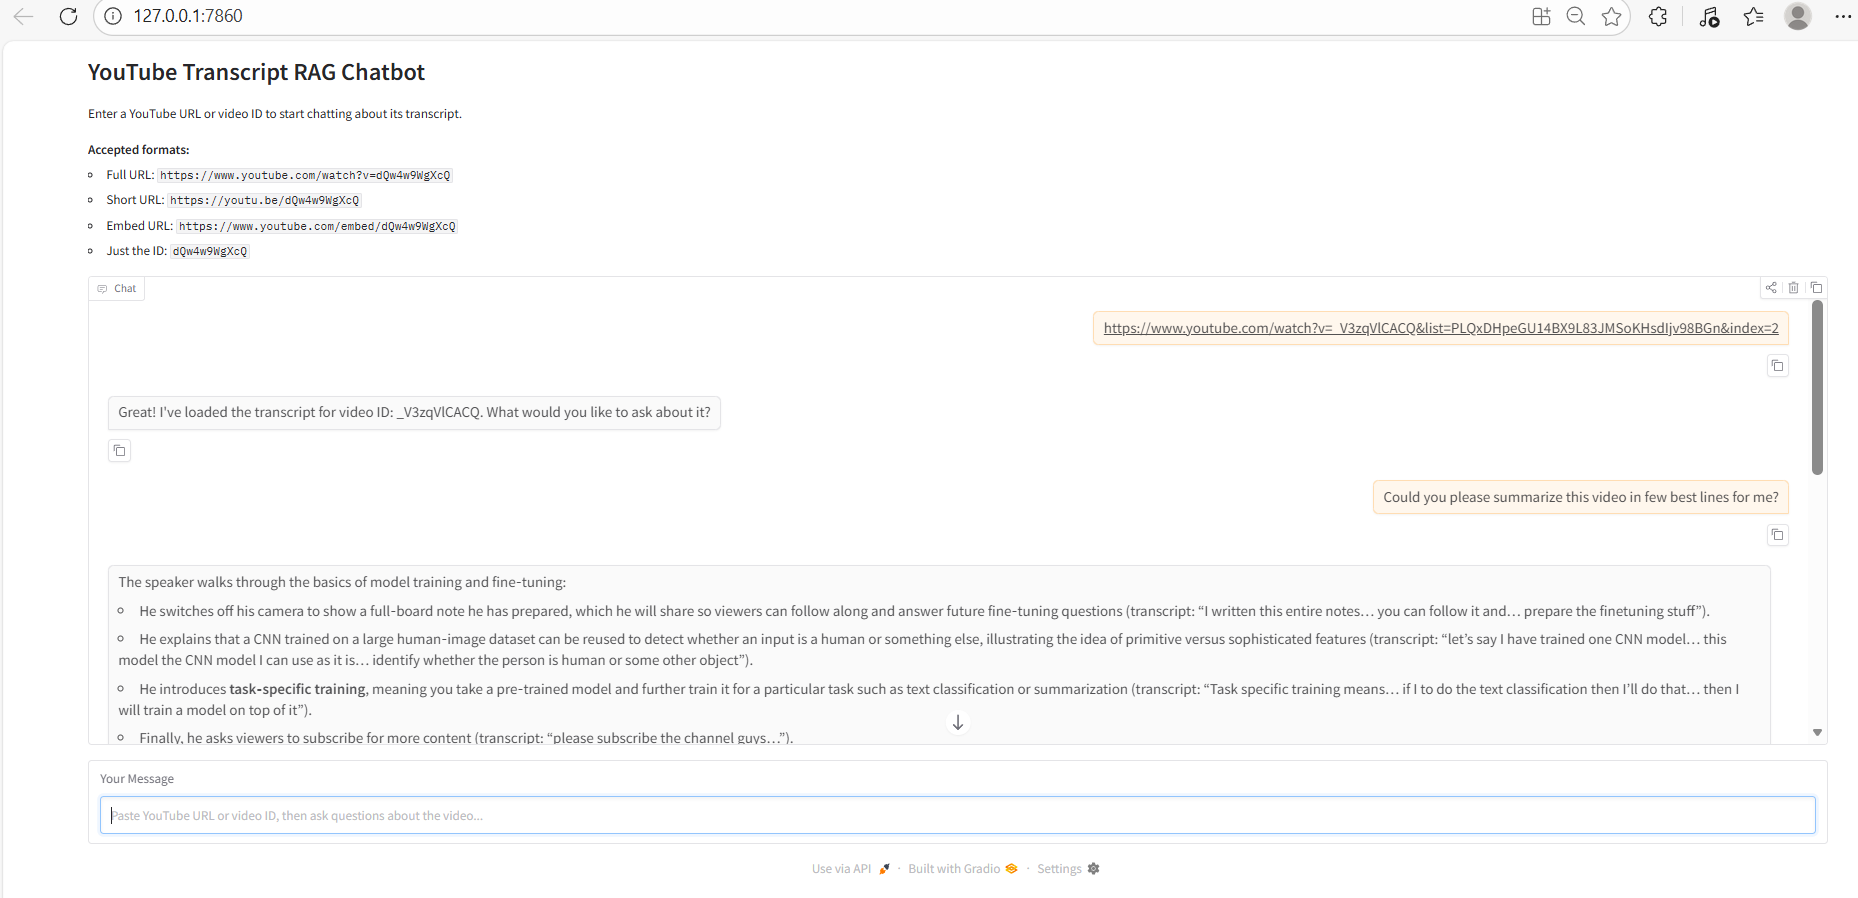